In [88]:
### Heat equation: du/dt = Laplace(u) + f

In [89]:
from fenics import *
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt

In [90]:
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t', degree=2, alpha=3, beta=1.2, t=0)

In [137]:
alpha = 6
u_D.alpha = alpha
beta = 1
u_D.beta = beta

In [138]:
# Create mesh and define function space
nx = ny = 8
nt = 20
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

In [139]:
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

In [140]:
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

In [141]:
#Initial
u_n = interpolate(u_D, V)

In [142]:
dt = 0.2

a = u*v*dx + dt*dot(grad(u), grad(v))*dx
L = (dt*f+u_n)*v*dx

In [143]:
u_hist = []
error_max_hist = []
t_hist = []

u = Function(V)
t = 0
for i in range(nt):
    t += dt
    u_D.t = t
    solve(a == L, u, bc)
    u_n.assign(u)
    
    vertex_values_u_D = u_D.compute_vertex_values(mesh).reshape(nx+1, ny+1)
    vertex_values_u = u.compute_vertex_values(mesh).reshape(nx+1, ny+1)
    error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
    
    t_hist.append(t)
    error_max_hist.append(error_max)
    u_hist.append(u.copy(deepcopy=True))

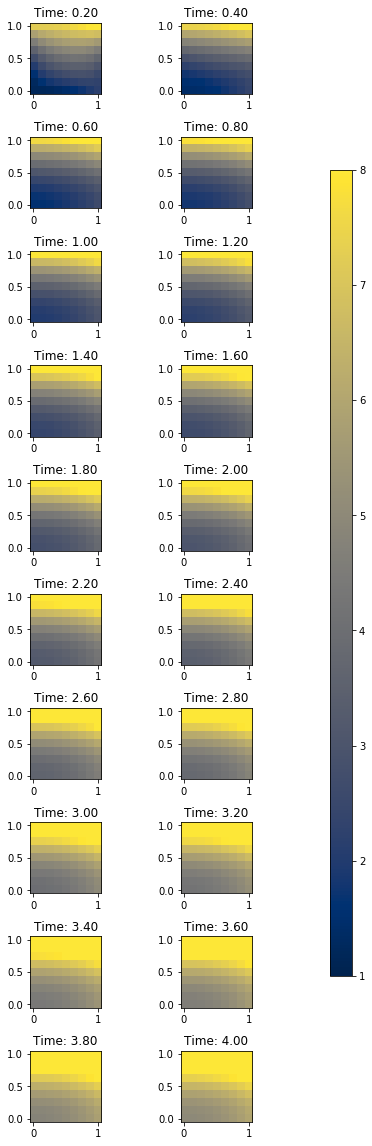

In [144]:
#settings
n_plots_max = nt # should be a constant in the order of ten for longer simulations
nrows, ncols = nt//2, 2  # array of sub-plots
figsize = [3*ncols, 0.8*nrows*2]     # figure size, inches
scalemin, scalemax = 1.0, 8.0 #Decided arbitrarily to scale the plots to a standard scale.
                           #Ideally, we would scale everything based on the min and max over all time,
                           #but here we are plotting before doing the entire calculation.
        

n_plots = min(nt, n_plots_max)
skipper = int(np.ceil(nt/n_plots))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)


for i in range(n_plots):
    axi = axes.flat[i]
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    vertex_values_u = u_hist[i].compute_vertex_values(mesh).reshape(nx+1, ny+1)
    img = axi.imshow(vertex_values_u, origin='lower', extent=(-0.05, 1.05, -0.05, 1.05), cmap='cividis', vmin=scalemin, vmax=scalemax)
    # write row/col indices as axes' title for identification
    axi.set_title(f'Time: {t_hist[i]:.2f}')
        

plt.tight_layout(True)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(error_max_hist)
plt.show()

In [22]:
### other

In [ ]:
uvals = u_hist[0].compute_vertex_values()
xyvals = mesh.coordinates()
xvals = xyvals[:,0]
yvals=xyvals[:,1]

xx = np.linspace(0,1)
yy = np.linspace(0,1)

XX, YY = np.meshgrid(xx,yy)

from scipy.interpolate import griddata
uu = griddata(xyvals, uvals, (XX, YY), method='linear')
plt.imshow(uu, origin='lower', extent=(-5e-3, 1+5e-3, -5e-3, 1+5e-3))

In [73]:
n_plots_max = 10
nrows, ncols = 5, 2  # array of sub-plots
figsize = [6, 8]     # figure size, inches
axes = np.arange(nrows*ncols).reshape(nrows, ncols)

n = 16
vals = np.arange(n)

n_plots = min(nt, n_plots_max)
skipper = int(np.floor(n/n_plots))

j = 0
for i in range(n):
    string = str(i)
    if i % skipper == 0 and j < n_plots:
        axi = axes.flat[j]
        string = string + ' '+str(vals[j])+' : '+str(axi)
        j += 1
    print(string)

0 0 : 0
1 1 : 1
2 2 : 2
3 3 : 3
4 4 : 4
5 5 : 5
6 6 : 6
7 7 : 7
8 8 : 8
9 9 : 9
10
11
12
13
14
15


In [69]:
print(skipper)
print(n_plots)

2
10
